In [ ]:
!pip install paddlepaddle

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import random
import paddle

# 选择运行设备
device = paddle.set_device('cpu')
# device = paddle.set_device('gpu:0')

In [ ]:
!wget https://www.dropbox.com/scl/fi/p65ovund8703i7mpk1ifz/food-11.zip?rlkey=5htz8xtxg3hc27lpqwqua3bd5&st=440pvik0&dl=0

--2025-01-02 02:59:49--  https://www.dropbox.com/scl/fi/p65ovund8703i7mpk1ifz/food-11.zip?rlkey=5htz8xtxg3hc27lpqwqua3bd5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6028:18::a27d:4712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca88603a7e1e72264eeb977de10.dl.dropboxusercontent.com/cd/0/inline/ChYDTFK55HqIL3BY0y5hwVLG-6NX941uXy_0VRKqhkWA62n5m6vCQLeJ1daQq0hlCZe0YmuxtY-hRqTeO-CaMjnu9ylWIMZEi1_rSQVkIYtIDZo7buTluBfx_kqIY6owgBgfdk12NSRL5vgN3uoVZ5_Z/file# [following]
--2025-01-02 02:59:49--  https://uca88603a7e1e72264eeb977de10.dl.dropboxusercontent.com/cd/0/inline/ChYDTFK55HqIL3BY0y5hwVLG-6NX941uXy_0VRKqhkWA62n5m6vCQLeJ1daQq0hlCZe0YmuxtY-hRqTeO-CaMjnu9ylWIMZEi1_rSQVkIYtIDZo7buTluBfx_kqIY6owgBgfdk12NSRL5vgN3uoVZ5_Z/file
Resolving uca88603a7e1e72264eeb977de10.dl.dropboxusercontent.com (uca88603a7e1e72264eeb977de10.dl.dropboxusercontent.com)... 162.125.6.15, 2620:1

In [ ]:
!unzip -q /content/food-11.zip # 解压缩food-11数据集

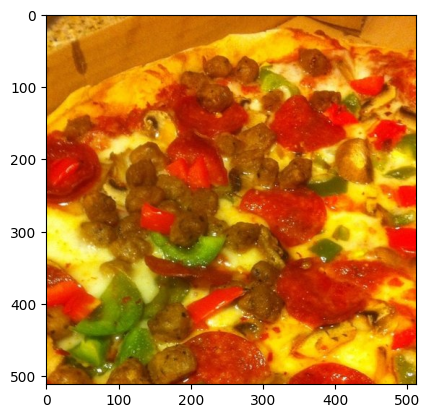

In [ ]:
# 观察样本
img = cv2.imread('/content/training/0_110.jpg')
plt.imshow(img[:,:,::-1])
plt.show()


In [ ]:
def preprocess(img,mode='train'):
    img = cv2.resize(img,(128,128))
    # 在训练集中随机对数据进行flip操作
    if mode == 'train':
        if random.randint(0,1): # 随机进行预处理
            img = cv2.flip(img,random.randint(-1,1))  # flip操作模式随机选择
    # 转换为numpy数组
    img = np.array(img).astype('float32')
    # 将数据范围改为0-1
    img = img / 255.
    # 最后更改数组的shape，使其符合CNN输入要求
    return img.transpose((2,0,1))

In [ ]:
class FoodDataSet(paddle.io.Dataset):
    def __init__(self,data_dir,mode):
        # 获取文件夹下数据名称列表
        self.filenames = os.listdir(data_dir)
        self.data_dir = data_dir
        self.mode = mode
    def __getitem__(self,index):
        file_name = self.data_dir + self.filenames[index]
        # 读取数据
        img = cv2.imread(file_name)
        # 预处理
        img = preprocess(img,mode = self.mode)
        # 获得标签
        label = int(self.filenames[index].split('_')[0])
        return img,label
    def __len__(self):
        return len(self.filenames)

train_dataset = FoodDataSet('/content/training/','train')
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), batch_size=64, shuffle=True)
eval_dataset = FoodDataSet('/content/validation/','validation')
eval_loader = paddle.io.DataLoader(eval_dataset, places=paddle.CPUPlace(), batch_size=64, shuffle=True)

In [ ]:
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet,self).__init__()

        self.conv0 = paddle.nn.Conv2D(in_channels=3,out_channels=10,kernel_size=5,padding="SAME",stride=1)
        self.pool0 = paddle.nn.MaxPool2D(kernel_size=2,stride=2) # 128 * 128 -> 64 * 64

        self.conv1 = paddle.nn.Conv2D(in_channels=10,out_channels=20,kernel_size=5,padding="SAME",stride=1)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2,stride=2) # 64 * 64 -> 32 * 32

        self.conv2 = paddle.nn.Conv2D(in_channels=20,out_channels=50,kernel_size=5,padding="SAME",stride=1)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2,stride=2) # 32 * 32 -> 16 * 16

        self.fc1 = paddle.nn.Linear(in_features=12800,out_features=256)
        self.fc2 = paddle.nn.Linear(in_features=256,out_features=64)
        self.fc3 = paddle.nn.Linear(in_features=64,out_features=11)

    def forward(self,x):
        x = self.conv0(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.pool0(x)

        x = self.conv1(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.pool2(x)

        x = paddle.reshape(x,[x.shape[0],-1])

        x = self.fc1(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.fc2(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.fc3(x)
        x = paddle.nn.functional.softmax(x)
        return x
network = LeNet()

In [ ]:
paddle.summary(network, (1,3,128,128))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 3, 128, 128]]   [1, 10, 128, 128]         760      
  MaxPool2D-1   [[1, 10, 128, 128]]    [1, 10, 64, 64]           0       
   Conv2D-2      [[1, 10, 64, 64]]     [1, 20, 64, 64]         5,020     
  MaxPool2D-2    [[1, 20, 64, 64]]     [1, 20, 32, 32]           0       
   Conv2D-3      [[1, 20, 32, 32]]     [1, 50, 32, 32]        25,050     
  MaxPool2D-3    [[1, 50, 32, 32]]     [1, 50, 16, 16]           0       
   Linear-1         [[1, 12800]]           [1, 256]          3,277,056   
   Linear-2          [[1, 256]]            [1, 64]            16,448     
   Linear-3          [[1, 64]]             [1, 11]              715      
Total params: 3,325,049
Trainable params: 3,325,049
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.19
Forward/ba

{'total_params': 3325049, 'trainable_params': 3325049}

In [ ]:
model = paddle.Model(network)

# 準備訓練
model.prepare(paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters()),
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy())

# 儲存模型
model.save('model/LeNet')

# 評估模型
model.evaluate(eval_dataset, batch_size=64, verbose=1)

# 測試模型
model_state_dict = paddle.load('model/LeNet.pdparams')
model = LeNet()
model.set_state_dict(model_state_dict)
model.eval()


Eval begin...
step 54/54 [==============================] - loss: 2.4059 - acc: 0.1157 - 1s/step          
Eval samples: 3430


In [ ]:
# 測試樣本
# 檢查並建立 testing 資料夾
test_dir = 'work/food-11/testing'
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)
    print("已建立空的 testing 資料夾。")

    # 生成一些隨機測試圖像（如果沒有測試資料）
    for i in range(10):
        random_image = np.random.randint(0, 255, (128, 128, 3), dtype=np.uint8)
        cv2.imwrite(f'{test_dir}/random_{i}.jpg', random_image)
    print("已生成測試圖像作為樣本資料。")

# 確認 testing 資料夾的內容
print("testing 資料夾內容：")
!ls {test_dir}

testing 資料夾內容：
random_0.jpg  random_2.jpg  random_4.jpg  random_6.jpg	random_8.jpg
random_1.jpg  random_3.jpg  random_5.jpg  random_7.jpg	random_9.jpg


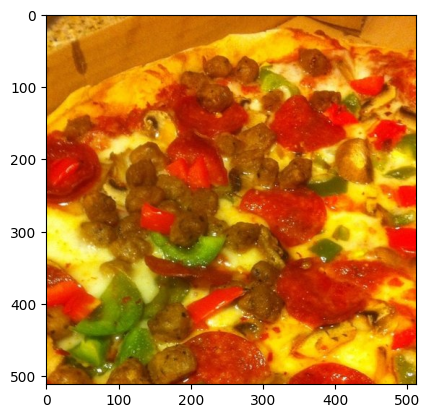

預測結果: 3


In [ ]:
# 測試樣本
img = cv2.imread('/content/training/0_110.jpg') # Reload original image

plt.imshow(img[:, :, ::-1])
plt.show()

img = preprocess(img, mode='test')
res = model(paddle.to_tensor(img[np.newaxis, :, :, :]))
print(f"預測結果: {np.argmax(res.numpy())}")